## CS-E4740 - Federated Learning D (Spring 25)

# Assignment 3: A FL Design Principle

### B. Zheng, A. Jung, and ChatGPT

<a id='varying_features'></a>
<div class="alert alert-warning">
    <h2>Deadline: 31.03.2025</h2>
</div>
    
<a id='varying_features'></a><div class="alert alert-info">

## Learning Goals:

After completing the notebook, you should

- be familiar with networkx and able to use it to build a FMI station graph,
- be able to solve GTVMin using closed-form,
- be able to solve GTVMin using gradient method.
    
## Backround Material

- Chapter 4 of [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)
- [Documentation of Python library networkx](https://networkx.org/)

## Importing necessary libraries

In [1]:
# Importing necessary libraries
import ast  # Abstract Syntax Trees for parsing and analyzing Python code structures
import copy  # Provides shallow and deep copy operations for objects
import numpy as np  # NumPy for numerical computations and array manipulations
from numpy import linalg  # Importing linear algebra submodule of NumPy for matrix operations
import pandas as pd  # Pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Matplotlib for data visualization
from scipy.linalg import block_diag  # block_diag for creating diagonalized matrix


# Scikit-learn methods for machine learning tasks
from sklearn.neighbors import kneighbors_graph  # Computes the k-nearest neighbor graph
from sklearn.metrics import mean_squared_error  # Measures the mean squared error for regression tasks
from sklearn.tree import DecisionTreeRegressor  # Decision Tree Regressor for predictive modeling
from sklearn.model_selection import train_test_split  # Splits dataset into training and test sets

# Importing NetworkX for graph-based data structures and algorithms
import networkx as nx  # NetworkX helps in creating, manipulating, and analyzing graph structures

### Helper functions

In [2]:
def plotFMI(G, save_path=None):
    """
    Generates a scatter plot of FMI stations.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node represents an FMI station, 
        containing:
        - 'coord' (tuple: latitude, longitude) for spatial positioning.

    save_path : str, optional
        If provided, saves the plot to the specified file path.

    Returns
    -------
    None
        Displays a scatter plot of stations, where:
        - Nodes are plotted based on their geographic coordinates.
        - Node labels correspond to their index in the coordinate array.
    """
    # Extract coordinates
    coords = np.array([G.nodes[node]['coord'] for node in G.nodes])

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Draw nodes
    ax.scatter(coords[:, 1], coords[:, 0], c='black', s=50, zorder=5)

    # Add labels
    for node, (lat, lon) in enumerate(coords):
        ax.text(lon + 0.1, lat + 0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')

    # Draw edges
    for u, v in G.edges:
        ax.plot([coords[u, 1], coords[v, 1]], [coords[u, 0], coords[v, 0]], linestyle='-', color='gray')

    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('FMI Stations')
    
    # Stretch according to Tissot's indicatrix
    ax.set_aspect(1.6)
    
    if save_path != None:
        try:
            plt.savefig(save_path)
        except: 
            print("The plot cannot be saved. The path is invalid. ")
            
    plt.show()
    
def add_edges(G, numneighbors=4):
    """Adds edges to a graph based on k-nearest neighbors using station coordinates.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node has a 'coord' attribute with (latitude, longitude).
    numneighbors : int, optional
        Number of nearest neighbors to connect to each node, by default 4.

    Returns
    -------
    networkx.Graph
        A new graph with added edges based on k-nearest neighbors.
    """
    # Deep copy the graph to avoid modifying the original
    graph_with_edges = copy.deepcopy(G)

    # Extract coordinates
    coords = np.array([graph_with_edges.nodes[node]['coord'] for node in graph_with_edges.nodes])

    # Create adjacency matrix using k-nearest neighbors
    adjacency_matrix = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)

    # Add edges based on the adjacency matrix
    edges = zip(*adjacency_matrix.nonzero())
    graph_with_edges.add_edges_from(edges)

    return graph_with_edges

## Get Data

We use the dataset stored in the file **'FMI_data_2025.csv'**. This dataset contains data points with the following properties(columns): 

- **Name**: The name of the weather station
- **Latitude**: The latitude of the weather station
- **Longitude**: The longitude of the weather station
- **Tmax**: The highest temperature recorded in the past five days
- **Tmin**: The lowest temperature recorded in the past five days
- **y_Tmax**: The highest temperature during a specific day
- **y_Tmin**: The lowest temperature during a specific day

Each station is identified by its name. And each station is a node in graph (we will build the graph later). 

Each row means temperature data of a station for 6 days, where `Tmax`/`Tmin` corresponding to the highest/lowest temperature in 5 days (we use them as features), `y_Tmax` corresponding to the highest temperature of the next day (we use it as label). 

Briefly speaking, in each row, we use `Tmax` and `Tmin` to predict `y_Tmax`. The term 'min' and 'max' here just helping you to understand where these data come from. We will not use `y_Tmin` in this assignment.

One example that may help you understand:

<center>
<img src="Data-explain.png" alt="data-explain" width="80%"/>
</center>

In [3]:
# Load the weather dataset
# This dataset contains weather measurements for different stations
# 'FMI_data_2025.csv' should be in the same directory as this script
# Ensure the file is available before running the script

data = pd.read_csv('FMI_data_2025.csv')

# Process relevant columns
# Create a new column 'X' that combines Tmax and Tmin values for each station
# This combines temperature measurements into a single representation

data['X'] = data.apply(lambda row: row['Tmax'] + row['Tmin'], axis=1)

# Convert the combined temperature values from string representation to a list format
# Some values may be stored as a string with '][', which is replaced and parsed correctly
data['X'] = data['X'].apply(lambda row: ast.literal_eval(row.replace('][', ', ')))

# Count the number of unique weather stations in the dataset
n_stations = len(data.Name.unique())
print(f"Number of unique stations: {n_stations}")

# Display the first five rows of the processed dataset
print(data.head())

Number of unique stations: 192
                              Name  Latitude  Longitude  \
0  Jomala Maarianhamina lentoasema  60.12735   19.90038   
1  Jomala Maarianhamina lentoasema  60.12735   19.90038   
2  Jomala Maarianhamina lentoasema  60.12735   19.90038   
3  Jomala Maarianhamina lentoasema  60.12735   19.90038   
4  Jomala Maarianhamina lentoasema  60.12735   19.90038   

                          Tmax                            Tmin  y_Tmax  \
0  [0.3, -1.9, -1.2, 5.4, 7.7]   [-2.6, -4.9, -5.1, -9.6, 4.4]     7.1   
1    [6.4, 4.6, 3.1, 5.9, 6.3]      [4.4, 2.2, -1.5, 3.0, 5.1]     5.8   
2   [4.7, -2.1, 3.2, 4.5, 4.0]   [-2.6, -9.1, -9.2, -0.7, 0.5]     2.7   
3    [2.7, 0.9, 4.2, 2.7, 1.1]  [-3.4, -4.2, -2.1, -3.7, -7.8]     3.7   
4    [2.4, 5.8, 4.5, 4.8, 6.4]    [-2.0, -0.2, 2.5, -5.6, 3.6]     4.7   

   y_Tmin                                                  X  
0     5.7  [0.3, -1.9, -1.2, 5.4, 7.7, -2.6, -4.9, -5.1, ...  
1     4.0  [6.4, 4.6, 3.1, 5.9, 6.3, 4.4, 2

<a id='varying_features'></a>
<div class=" alert alert-warning">

### Task 3.1 - Building a FMI Network

Generate a FL network $\mathcal{G}^{(\mathrm{FMI})}$ with nodes $i=1, \ldots, n$ representing the FMI stations listed in the above dataset.

- Node $i$ carries a local dataset $\mathcal{D}^{(i)}$ that consists of data points that represent daily weather conditions at the corresponding FMI station. The features of a data point (representing a specific day) are the maximum and minimum daytime temperature during that day and the previous 4 days (5 days in total). The label of a data point is the maximum daytime temperature during the following day.

- Split data in each node into `X_train, X_val, y_train, y_val`, with `test_size=0.2` `random_state=42`, we might need to convert the data type to `float`

- Construct edges $\mathcal{E}$ of $\mathcal{G}^{(\mathrm{FMI})}$ by connecting each node to its **4** nearest neighbours. We measure distance between FMI stations $i, i^{\prime}$ by $\left\|\mathbf{z}^{(i)}-\mathbf{z}^{\left(i^{\prime}\right)}\right\|_2$, $\mathbf{z}^{(i)}=(\text { lat, lon })^T$ with latitude and longitude of FMI station. You can use the helper function `add_edges`.
</div>

In [4]:
# Create a networkX graph
G_FMI_no_edges = nx.Graph()

# Add a one node per station
G_FMI_no_edges.add_nodes_from(range(0, n_stations))

for i, station in enumerate(data.Name.unique()):
    
    # Extract data of a certain station
    station_data = data[data.Name==station]
    
    X_node = station_data['X'].to_numpy().reshape(-1, 1)
    y_node = station_data['y_Tmax'].to_numpy().reshape(-1, 1)
    
    X_train, X_val, y_train, y_val = train_test_split(X_node, 
                                                        y_node, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    # Assign node attributes
    # G_FMI_no_edges.nodes[i].update({
    #     'name': ?,
    #     'X_train': ?,
    #     'y_train': ?,
    #     'X_val': ?,
    #     'y_val': ?,
    #     'weights': you can assume all weights as 0,
    #     'coord': ?
    # })
    
    # YOUR CODE HERE
    G_FMI_no_edges.nodes[i].update({
        'name': station,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'weights': 0,
        'coord': (station_data.iloc[0]['Latitude'], station_data.iloc[0]['Longitude'])
    })


# Add edges between each station and its nearest 4 neighbors.
# G_FMI = add_edges(??)

# YOUR CODE HERE
G_FMI = add_edges(G_FMI_no_edges, numneighbors=4)

# NOTE: The empirical graph is connected with numneighbors=4
print("The empirical graph is connected:", nx.is_connected(G_FMI))


The empirical graph is connected: True


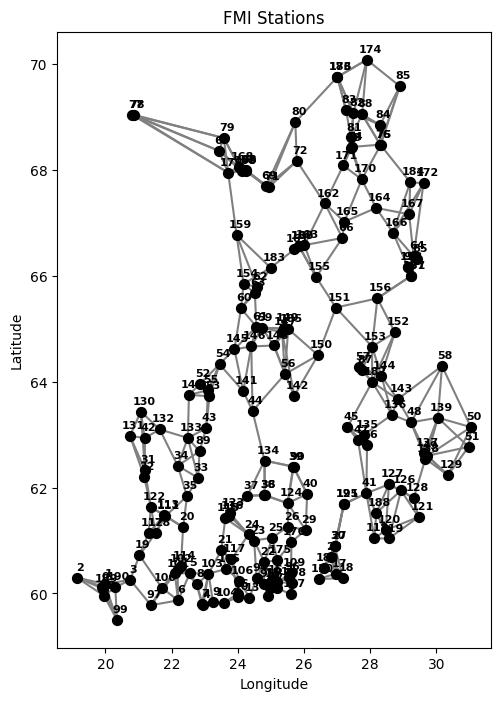

In [5]:
# Convert data type for X 
for node in G_FMI.nodes:
    X_train_obj = G_FMI.nodes[node]['X_train'] 
    X_train_array = np.array([row[0] for row in X_train_obj], dtype=float)
    G_FMI.nodes[node]['X_train'] = X_train_array
    
    X_val_obj = G_FMI.nodes[node]['X_val'] 
    X_val_array = np.array([row[0] for row in X_val_obj], dtype=float)
    G_FMI.nodes[node]['X_val'] = X_val_array

# Visualize the empirical graph
plotFMI(G_FMI)

In [6]:
# Sanity check 

attributes = set(G_FMI.nodes[0].keys())
assert (set(['name', 'X_train', 'y_train', 'X_val', 'y_val', 'weights', 'coord']) == attributes), 'Some attributes have not been found!'

assert(G_FMI.number_of_nodes() == 192), "Should have 192 nodes"
assert(G_FMI.number_of_edges() == 486), "Should have 486 edges with neighbors=4"
assert([np.all(G_FMI.nodes[i]['X_train'].shape == (8,10) for i in range(G_FMI.number_of_nodes()))]), "X_train shape for each node should be (8,10)"
assert([np.all(G_FMI.nodes[i]['X_val'].shape == (2,10) for i in range(G_FMI.number_of_nodes()))]), "X_val shape for each node should be (2,10)"
assert([np.all(G_FMI.nodes[i]['y_train'].shape == (8,1) for i in range(G_FMI.number_of_nodes()))]), "y_train shape for each node should be (8,1)"
assert([np.all(G_FMI.nodes[i]['y_val'].shape == (2,10) for i in range(G_FMI.number_of_nodes()))]), "y_val shape for each node should be (2,10)"

assert([np.all(G_FMI.nodes[i]['X_train'].dtype == np.float64 for i in range(G_FMI.number_of_nodes()))]), "data type should be float64"
assert([np.all(G_FMI.nodes[i]['y_train'].dtype == np.float64 for i in range(G_FMI.number_of_nodes()))]), "data type should be float64"
assert([np.all(G_FMI.nodes[i]['X_val'].dtype == np.float64 for i in range(G_FMI.number_of_nodes()))]), "data type should be float64"
assert([np.all(G_FMI.nodes[i]['y_val'].dtype == np.float64 for i in range(G_FMI.number_of_nodes()))]), "data type should be float64"

print('Sanity check passed!')


Sanity check passed!


## GTVMin for Local Linear Regression

Generalized Total Variation Minimization (GTVMin) optimally balances the (average) local loss and the GTV of local model parameters $\mathbf{w}^{(i)}$

$$\left\{\widehat{\mathbf{w}}^{(i)}\right\}_{i=1}^n \in \operatorname{argmin} \sum_{i \in \mathcal{V}} L_i\left(\mathbf{w}^{(i)}\right)+\alpha \sum_{\left\{i, i^{\prime}\right\} \in \mathcal{E}} A_{i, i^{\prime}} \phi\left(\mathbf{w}^{(i)}-\mathbf{w}^{\left(i^{\prime}\right)}\right)$$

For linear hypothesis  $h^{(i)}(\mathbf{x}):=\left(\mathbf{w}^{(i)}\right)^T \mathbf{x}$  and MSE loss:
  

$$
\begin{aligned}
L_i\left(\mathbf{w}^{(i)}\right): & =\left(1 / m_i\right) \sum_{r=1}^{m_i}\left(y^{(i, r)}-\left(\mathbf{w}^{(i)}\right)^T \mathbf{x}^{(i, r)}\right)^2 \\
& =\left(1 / m_i\right)\left\|\mathbf{y}^{(i)}-\mathbf{X}^{(i)} \mathbf{w}^{(i)}\right\|_2^2
\end{aligned}
$$

  

where $m_i$ is number of elements of node $i$.

  




<a id='varying_features'></a>
<div class=" alert alert-warning">

### Task 3.2 - Solve GTVMin using closed form

The linear local model has some nice properties which allow us to solve it in closed form. In this task, you will use method introduced in [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf) Section 3.4.1

**Instruction**:

For each node $i$, first we define 

$$\mathbf{Q}^{(i)}=\left(1 / m_i\right)\left(\mathbf{X}^{(i)}\right)^T \mathbf{X}^{(i)}$$

and 
$$\mathbf{q}^{(i)}:=\left(-2 / m_i\right)\left(\mathbf{X}^{(i)}\right)^T \mathbf{y}^{(i)}$$

where $\mathbf{X}$ is feature matrix and $\mathbf{y}$ is label matrix
  

Then defining $\mathbf{Q}$ by stacking $\mathbf{Q}^{(i)}$ togethe:

  

$$
\mathbf{Q}:=\left(\begin{array}{cccc}
\mathbf{Q}^{(1)} & \mathbf{0} & \cdots & \mathbf{0} \\
\mathbf{0} & \mathbf{Q}^{(2)} & \cdots & \mathbf{0} \\
\vdots & \vdots & \ddots & \vdots \\
\mathbf{0} & \mathbf{0} & \cdots & \mathbf{Q}^{(n)}
\end{array}\right)+\alpha \mathbf{L}^{(\mathcal{G})} \otimes \mathbf{I}
$$

  

where $\mathbf{L}^{(\mathcal{G})}$ is Laplician matrix for empirical graph, $\alpha$ is GTVMin parameter, $\otimes$ is Kronecker Product

Defining $\mathbf{q}$ by stacking $\mathbf{q}^{(i)}$ together:

$$\mathbf{q}:=\left(\left(\mathbf{q}^{(1)}\right)^T, \ldots,\left(\mathbf{q}^{(n)}\right)^T\right)^T$$

After some algebra, the objective of GTVMin (for local linear models $\mathcal{H}:=\left\{h:h(x)=\mathbf{w}^T \mathbf{x}\right\}$) becomes a convex quadratic function:

  

$$
\left\{\widehat{\mathbf{w}}^{(i)}\right\}_{i=1}^n \in \operatorname{argmin} \mathbf{w}^T \mathbf{Q} \mathbf{w}+\mathbf{q}^T \mathbf{w}
$$

(💡 Why is this convex quadratic function?)

If the matrix $\mathbf{Q}$ is invertible, the $\widehat{\mathbf{w}}$ is unique and given by:

  

$$\widehat{\mathbf{w}}=(-1 / 2) \mathbf{Q}^{-1} \mathbf{q}$$


</div>

<a id='varying_features'></a>
<div class=" alert alert-warning">

#### 3.2.1 $\mathbf{Q}^{(i)}$ & $\mathbf{q}^{(i)}$

Compute 

$$\mathbf{Q}^{(i)}=\left(1 / m_i\right)\left(\mathbf{X}^{(i)}\right)^T \mathbf{X}^{(i)}$$

And 

$$\mathbf{q}^{(i)}:=\left(-2 / m_i\right)\left(\mathbf{X}^{(i)}\right)^T \mathbf{y}^{(i)}$$

for each node $i$

</div>

In [7]:
def compute_Qi(X):
    """
    Compute the matrix Q^(i) for a single node's data.

    The computation follows:
        Q^(i) = (1 / m_i) * X^T * X

    where:
    - X is a matrix of shape (m_i, d), representing m_i samples with d features.
    - m_i is the number of samples.

    Parameters
    ----------
    X : numpy.ndarray
        A 2D array of shape (m_i, d) representing the data matrix for a node.

    Returns
    -------
    numpy.ndarray
        A square matrix of shape (d, d) representing the computed Q^(i).
    """
    # YOUR CODE HERE
    m_i = X.shape[0]  # Number of samples
    return (1 / m_i) * (X.T @ X)

def compute_qi(X, y):
    """
    Compute the vector q^(i) for a single node's data.

    The computation follows:
        q^(i) = (-2 / m_i) * X^T * y

    where:
    - X is a matrix of shape (m_i, d), representing m_i samples with d features.
    - y is a vector of shape (m_i,), representing target values.
    - m_i is the number of samples.

    Parameters
    ----------
    X : numpy.ndarray
        A 2D array of shape (m_i, d) representing the feature matrix for a node.
    y : numpy.ndarray
        A 1D array of shape (m_i,) representing the target values.

    Returns
    -------
    numpy.ndarray
        A column vector of shape (d, 1) representing the computed q^(i).
    """
    # YOUR CODE HERE
    m_i = X.shape[0]  # Number of samples
    return (-2 / m_i) * (X.T @ y.reshape(-1, 1))

In [8]:
# Sanity check 

X_train_0 = G_FMI.nodes[0]['X_train']
y_train_0 = G_FMI.nodes[0]['y_train']

Qi_0 = compute_Qi(X_train_0)
qi_0 = compute_qi(X_train_0, y_train_0)

assert(Qi_0.shape == (10,10))
assert(qi_0.shape == (10,1))

print('Sanity check passed!')


Sanity check passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">

#### 3.2.2 $\mathbf{Q}$ & $\mathbf{q}$

Stack $\mathbf{Q}^{(i)}$ and combine with $\mathbf{L}^{(\mathcal{G})}$ to compute $\mathbf{Q}$

$$
\mathbf{Q}:=\operatorname{diag}(\mathbf{Q}^{(i)})+\alpha \mathbf{L}^{(\mathcal{G})} \otimes \mathbf{I}
$$

Stack $\mathbf{q}^{(i)}$

$$\mathbf{q} :=\operatorname{vstack}(\mathbf{q}^{(i)})$$

</div>

In [9]:
def compute_stack_Qi_q(G):
    """
    Compute and stack Q^(i) and q^(i) matrices for all nodes in a given graph G.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node contains:
        - 'X_train' : numpy.ndarray of shape (m_i, d) representing input features.
        - 'y_train' : numpy.ndarray of shape (m_i,) representing target values.

    Returns
    -------
    Qi_blockdiag : numpy.ndarray
        A block diagonal matrix of shape (n*d, n*d) where each Q^(i) is placed along the diagonal.
    q_stacked : numpy.ndarray
        A stacked column vector of shape (n*d, 1) where each q^(i) is vertically stacked.
    """

    nodes = list(G.nodes)

    # hint:
    # Qi_blockdiag = ??     # shape: (n*d, n*d)
    # q_stacked = ??        # shape: (n*d, 1)
    # we will use compute_Qi() and compute_qi() written earlier

    # YOUR CODE HERE
    Q_list = []
    q_list = []

    for node in G.nodes:
        X_train = G.nodes[node]['X_train']
        y_train = G.nodes[node]['y_train']

        Qi = compute_Qi(X_train)
        qi = compute_qi(X_train, y_train)

        Q_list.append(Qi)
        q_list.append(qi)

    Qi_blockdiag = block_diag(*Q_list)  # Construct block diagonal matrix
    q_stacked = np.vstack(q_list)  # Stack q^(i) vectors

    return Qi_blockdiag, q_stacked
    
def compute_Q(G, Qi_blockdiag, alpha=1):
    """
    Compute the global matrix Q for a given graph G.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node contains 'X_train', which determines the feature dimension.
    Qi_blockdiag : numpy.ndarray
        A block diagonal matrix of shape (n*d, n*d) containing per-node Q^(i) matrices.
    alpha : float, optional
        Regularization parameter for the Laplacian term (default is 1).

    Returns
    -------
    Q : numpy.ndarray
        A matrix of shape (n*d, n*d) computed as Q_blockdiag + alpha * (L ⊗ I_d).
    """
    
    # Dimension of data
    d = G.nodes[0]['X_train'].shape[1]
    
    # Laplician matrix 
    L = nx.laplacian_matrix(G).toarray()  # shape: (n, n)
    
    # Hint: use np.kron() for ⊗
    # I_d = ?
    # Q = ?
    
    # YOUR CODE HERE
    I_d = np.eye(d)  # Identity matrix of size d
    Q = Qi_blockdiag + alpha * np.kron(L, I_d)  # Compute Q using Kronecker product
    
    return Q

In [10]:
Qi_blockdiag, q_stacked= compute_stack_Qi_q(G_FMI)
# Set alpha = 1
Q = compute_Q(G_FMI, Qi_blockdiag, alpha=1)

# Sanity check 

assert(q_stacked.shape == (1920,1))
assert(Q.shape == (1920,1920))

print('Sanity check passed!')


Sanity check passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">


#### 3.2.3 $\widehat{\mathbf{w}}$

Compute $\widehat{\mathbf{w}}$

$$\widehat{\mathbf{w}}=(-1 / 2) \mathbf{Q}^{-1} \mathbf{q}$$

</div>

In [11]:
def compute_w(Q, q):
    """
    Solve the system of linear equations Qw = -0.5 * q to compute w_hat.

    Parameters
    ----------
    Q : numpy.ndarray
        A square matrix of shape (n*d, n*d).
    q : numpy.ndarray
        A column vector of shape (n*d, 1).

    Returns
    -------
    w_hat : numpy.ndarray
        The computed weight vector of shape (n*d, 1).
    """

    # Hint: linalg.solve Qx = q instead of matrix invert
    
    # YOUR CODE HERE
    w_hat = np.linalg.solve(Q, -0.5 * q)
    
    return w_hat

In [12]:
w_hat = compute_w(Q, q_stacked)

# Sanity check 

assert(w_hat.shape == (1920,1))
print('Sanity check passed!')



Sanity check passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">

### Task 3.3 - Solve GTVMin using gradient

__Task description:__

Closed form is compact but not always practical. One common optimization in machine learning is gradient descent:

$$\mathbf{w}^{(k+1)}:=\mathbf{w}^{(k)}-\eta \nabla f\left(\mathbf{w}^{(k)}\right)$$



Your task is to solve the instance of GTVMin using FedGD Algorithm5.1 from [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)

**Instruction:**

(1) Compute local gradient

$$\left(2 / m_i\right)\left(\mathbf{X}^{(i)}\right)^T\left(\mathbf{y}^{(i)}-\mathbf{X}^{(i)} \mathbf{w}^{(i, k)}\right)$$

(2) Compute graph penatly 

$$2 \alpha \sum A_{i, i^{\prime}}\left(\mathbf{w}^{\left(i^{\prime}, k\right)}-\mathbf{w}^{(i, k)}\right)$$

(3) Combine them according to Section 5.3 from [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)

</div>

In [13]:
def fedgd_linear(graph, alpha=1.0, eta=0.001, max_iter=100):    
    """
    Perform Federated Gradient Descent (FedGD) on a graph G for a linear model.

    This function iteratively updates local model weights for each node in the graph 
    using Mean Squared Error (MSE) gradient descent. It also incorporates a graph-based 
    penalty term to encourage similar weights among neighboring nodes.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node represents a dataset and contains:
        - 'X_train' : numpy.ndarray of shape (m_i, d), local training features
        - 'y_train' : numpy.ndarray of shape (m_i,), local training targets
        - 'w'       : numpy.ndarray of shape (d, 1), initialized model weights (randomized)
    alpha : float, optional
        Regularization parameter for the neighbor penalty (default is 1.0).
    eta : float, optional
        Learning rate for gradient updates (default is 0.001).
    max_iter : int, optional
        Number of gradient descent iterations (default is 100).

    Returns
    -------
    G : networkx.Graph
        The updated graph with optimized model weights for each node.
    """
    # Define the random seed
    np.random.seed(42)
    
    # Deep copy the input graph
    G = copy.deepcopy(graph)
    
    # Initialize weights
    for node in G.nodes():
        d = (10,1)
        w_init = np.random.uniform(low=-1.0, high=1.0, size=d)
        G.nodes[node]['w'] = w_init

    for _ in range(max_iter):
        # Temporary dict to store newly computed weights before synchronization
        w_new = {}

        # Compute updates for each node
        for node in G.nodes():
            # Extract the current local weight
            w_i_k = G.nodes[node]['w']

            # Local training data
            X_train = G.nodes[node]['X_train']
            y_train = G.nodes[node]['y_train']
            
            # (I) Local gradient (MSE derivative) 
            # grad_local = ?
            
            # YOUR CODE HERE
            # grad_local = (2 / m_i) * X^T * (y - Xw) where m_i is number of samples
            m_i = len(y_train)
            grad_local = (2 / m_i) * np.dot(X_train.T, (y_train - np.dot(X_train, w_i_k)))
            

            # (II) Graph (neighbor) penalty
            # grad_graph = ?
            
            # YOUR CODE HERE
            grad_graph = np.zeros_like(w_i_k)

            # Combine
            grad_total = -(grad_local + grad_graph)

            # Update rule
            # w_i_next = ?
            
            # YOUR CODE HERE
            # Update rule: w_i_next = w_i_k - eta * grad_total
            w_i_next = w_i_k - eta * grad_total

            # Store the updated weight
            w_new[node] = w_i_next

        # Synchronize all weights
        for node in G.nodes():
            G.nodes[node]['w'] = w_new[node]

    return G

In [14]:
# You can adjust alpha, eta, max_iter to see the trade-off between local loss and global loss
alpha=1
eta=0.0001
max_iter=100

G_fedgd = fedgd_linear(
    G_FMI,
    alpha=alpha,
    eta=eta,
    max_iter=max_iter
)

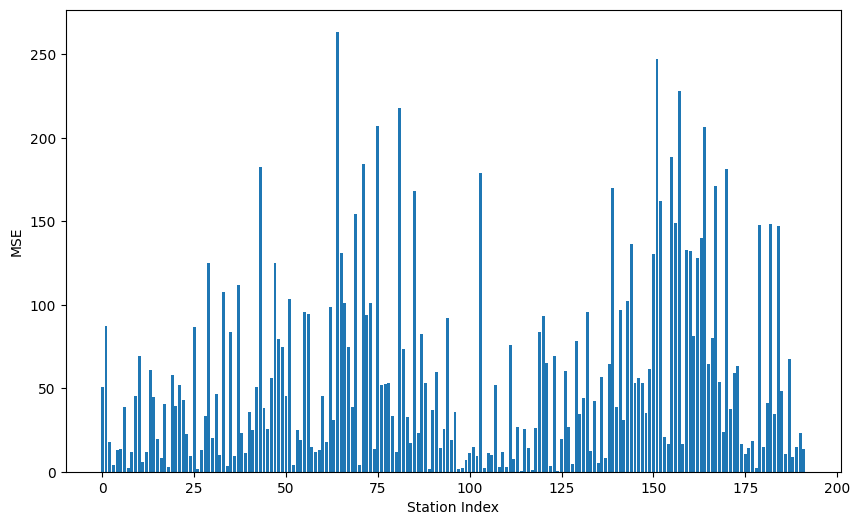

Average MSE: 57.24355622930756


In [15]:
# MSE results

mse_list = []
for node in G_fedgd.nodes():
    w_final = G_fedgd.nodes[node]['w']
    X_val_local = G_fedgd.nodes[node]['X_val']
    y_val_local = G_fedgd.nodes[node]['y_val']
    y_pred = X_val_local @ w_final
    mse = mean_squared_error(y_val_local, y_pred)
    mse_list.append(mse)

plt.figure(figsize=(10, 6))
plt.bar(range(len(mse_list)), mse_list)
plt.xlabel('Station Index')
plt.ylabel('MSE')
plt.show()

avg_mse = np.mean(mse_list)
print("Average MSE:", avg_mse)

In [16]:
# Sanity check

assert(avg_mse<100), "Try to achieve a better result."
print('Sanity check passed!')


Sanity check passed!
